In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import traffic
import numpy as np
import pyproj
from scipy.spatial.distance import cdist

In [2]:
airprox_gdf = gpd.GeoDataFrame(pd.read_pickle('../data/airprox_asp_2000_2021.pkl'))
# tfc_clean = traffic.core.Traffic.from_file('../data/cornwall_tfc_clean_30s_lt3000ft_2019_filt10.pkl')
tfc_clean = traffic.core.Traffic.from_file('../data/soton_tfc_clean_lt5000ft_201901.pkl')

In [3]:
tfc_clean.data.head()

,timestamp,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,latitude,longitude,onground,spi,squawk,track,vertical_rate,flight_id,track_unwrapped
0,2019-01-20 12:32:02+00:00,False,225.0,A7HHJ,475.0,148.0,2019-01-20 12:00:00+00:00,06a014,51.277802,-0.77034,False,False,5266,62.223436,1920.0,A7HHJ_007,62.223436
1,2019-01-20 12:32:03+00:00,False,275.0,A7HHJ,550.0,148.0,2019-01-20 12:00:00+00:00,06a014,51.278137,-0.76934,False,False,5266,62.223436,2048.0,A7HHJ_007,62.223436
2,2019-01-20 12:32:04+00:00,False,312.5,A7HHJ,550.0,148.0,2019-01-20 12:00:00+00:00,06a014,51.278295,-0.76881,False,False,5266,62.223436,2048.0,A7HHJ_007,62.223436
3,2019-01-20 12:32:05+00:00,False,350.0,A7HHJ,600.0,148.0,2019-01-20 12:00:00+00:00,06a014,51.278454,-0.76828,False,False,5266,62.744672,2304.0,A7HHJ_007,62.744672
4,2019-01-20 12:32:06+00:00,False,375.0,A7HHJ,650.0,148.0,2019-01-20 12:00:00+00:00,06a014,51.278919,-0.76683,False,False,5266,62.744672,2432.0,A7HHJ_007,62.744672


In [63]:
tfc_agg = tfc_clean.compute_xy('epsg:3857').assign(
    x=lambda elt: (elt.x // 4000) * 4000,
    y=lambda elt: (elt.y // 4000) * 4000,
).groupby(["x", "y"]).agg(altitude_mean=pd.NamedAgg('altitude', np.mean),
                          altitude_std=pd.NamedAgg('altitude', np.std), track_mean=pd.NamedAgg('track', np.mean),
                          track_std=pd.NamedAgg('track', np.std), groundspeed_mean=pd.NamedAgg('groundspeed', np.mean),
                          groundspeed_std=pd.NamedAgg('groundspeed', np.std), flight_id_nunique=('flight_id', 'nunique'))

In [64]:
tfc_agg.head(10)

altitude_mean  altitude_std  track_mean   track_std  \
x         y                                                                
-260000.0 6568000.0     1475.00000           NaN  102.319445         NaN   
          6572000.0     2150.00000    649.519053  190.602447   32.122473   
          6576000.0     1525.00000    303.108891  208.276866  164.630431   
          6608000.0     1556.25000    154.616461  253.422456   71.752955   
          6612000.0     1730.00000    224.582947  259.879111   71.933323   
          6620000.0     1925.00000           NaN  242.140349         NaN   
          6632000.0     2300.90254      0.599570  146.433361   63.342672   
          6636000.0     2045.00000    537.587202  192.996161   53.246867   
          6648000.0      800.00000      0.000000  192.283955    0.000000   
          6652000.0            NaN           NaN  217.596271         NaN   

                     groundspeed_mean  groundspeed_std  flight_id_nunique  
x         y                                                                
-260000.0 6568000.0         86.000000              NaN                  1  
          6572000.0        127.333333         4.618802                  2  
          6576000.0         81.000000         9.539392                  2  
          6608000.0        118.000000        12.000000                  3  
          6612000.0        106.600000        10.212737                  3  
          6620000.0         79.000000              NaN                  1  
          6632000.0         65.536415         1.933923                  2  
          6636000.0         76.600000        18.130392                  2  
          6648000.0        127.000000         0.000000                  1  
          6652000.0        127.000000              NaN                  1

In [65]:
# tfc_agg.to_pickle('../data/cornwall_tfc_clean_30s_lt3000ft_2019_filt10_aggxy.pkl')

In [66]:
# airprox_gdf = gpd.GeoDataFrame(pd.read_pickle('../data/airprox_asp_2000_2021.pkl'))
# tfc_agg = pd.read_pickle('../data/cornwall_tfc_clean_30s_lt3000ft_2019_filt10_aggxy.pkl')
pd.__version__

'1.4.3'

In [67]:
airprox_gdf.head()

,Latitude,Longitude,Altitude,Risk,Aircraft1_Classification,Aircraft1_Category,Aircraft1_Type,Aircraft1_FlightRules,Aircraft2_Classification,Aircraft2_Category,...,y,geometry,index_right,name,type,icaoClass,activity,country,lowerLimit_value,upperLimit_value
1814,51.050000,-0.616667,25000.0,c,commercial_air_transport,civil_air_transport_(scheduled_passenger),BOEING B757,ifr,general_aviation,civil_commercial_(hire_&_reward),...,1152.236497,POINT Z (-0.61667 51.05000 25000.00000),307,LONDON TMA,0,0,0,GB,2500,19500
2892,51.283333,-0.566667,1100.0,b,general_aviation,rotorcraft_-_helicopter,EUROCOPTER - EC155,ifr,general_aviation,fixed_wing_-_aeroplane,...,27137.096995,POINT Z (-0.56667 51.28333 1100.00000),307,LONDON TMA,0,0,0,GB,2500,19500
40,51.116667,-0.533333,500.0,d,general_aviation,rotorcraft_-_helicopter,AGUSTA - A109,vfr,military,rotorcraft_-_helicopter,...,8615.430463,POINT Z (-0.53333 51.11667 500.00000),307,LONDON TMA,0,0,0,GB,2500,19500
1010,51.133333,-0.666667,2000.0,c,general_aviation,fixed_wing_-_aeroplane,CESSNA - 150,vfr,general_aviation,fixed_wing_-_aeroplane,...,10397.680010,POINT Z (-0.66667 51.13333 2000.00000),307,LONDON TMA,0,0,0,GB,2500,19500
3217,51.250000,-0.600000,2400.0,a,general_aviation,fixed_wing_-_aeroplane,PIPER - PA28,vfr,general_aviation,fixed_wing_-_aeroplane,...,23410.351043,POINT Z (-0.60000 51.25000 2400.00000),307,LONDON TMA,0,0,0,GB,2500,19500


In [68]:
x_idx = np.array(tfc_agg.index.levels[0])
y_idx = np.array(tfc_agg.index.levels[1])


In [69]:
airprox_gdf = airprox_gdf[
    (airprox_gdf.Latitude >= tfc_clean.data.latitude.min()) &
    (airprox_gdf.Latitude <= tfc_clean.data.latitude.max()) &
    (airprox_gdf.Longitude >= tfc_clean.data.longitude.min()) &
    (airprox_gdf.Longitude <= tfc_clean.data.longitude.max())]

In [70]:
tfc_proj = pyproj.Proj(
    proj="lcc",
    ellps="WGS84",
    lat_1=tfc_clean.data.latitude.min(),
    lat_2=tfc_clean.data.latitude.max(),
    lat_0=tfc_clean.data.latitude.mean(),
    lon_0=tfc_clean.data.longitude.mean(),
)
transformer = pyproj.Transformer.from_proj(pyproj.Proj("epsg:4326"), tfc_proj, always_xy=True)
x, y = transformer.transform(
    airprox_gdf.Longitude.values,
    airprox_gdf.Latitude.values,
)
airprox_gdf = airprox_gdf.assign(x=x, y=y)

In [71]:
airprox_gdf

,Latitude,Longitude,Altitude,Risk,Aircraft1_Classification,Aircraft1_Category,Aircraft1_Type,Aircraft1_FlightRules,Aircraft2_Classification,Aircraft2_Category,...,y,geometry,index_right,name,type,icaoClass,activity,country,lowerLimit_value,upperLimit_value
1814,51.050000,-0.616667,25000.0,c,commercial_air_transport,civil_air_transport_(scheduled_passenger),BOEING B757,ifr,general_aviation,civil_commercial_(hire_&_reward),...,1152.236497,POINT Z (-0.61667 51.05000 25000.00000),307,LONDON TMA,0,0,0,GB,2500,19500
2892,51.283333,-0.566667,1100.0,b,general_aviation,rotorcraft_-_helicopter,EUROCOPTER - EC155,ifr,general_aviation,fixed_wing_-_aeroplane,...,27137.096995,POINT Z (-0.56667 51.28333 1100.00000),307,LONDON TMA,0,0,0,GB,2500,19500
40,51.116667,-0.533333,500.0,d,general_aviation,rotorcraft_-_helicopter,AGUSTA - A109,vfr,military,rotorcraft_-_helicopter,...,8615.430463,POINT Z (-0.53333 51.11667 500.00000),307,LONDON TMA,0,0,0,GB,2500,19500
1010,51.133333,-0.666667,2000.0,c,general_aviation,fixed_wing_-_aeroplane,CESSNA - 150,vfr,general_aviation,fixed_wing_-_aeroplane,...,10397.680010,POINT Z (-0.66667 51.13333 2000.00000),307,LONDON TMA,0,0,0,GB,2500,19500
3217,51.250000,-0.600000,2400.0,a,general_aviation,fixed_wing_-_aeroplane,PIPER - PA28,vfr,general_aviation,fixed_wing_-_aeroplane,...,23410.351043,POINT Z (-0.60000 51.25000 2400.00000),307,LONDON TMA,0,0,0,GB,2500,19500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,50.633333,-1.516667,2100.0,b,general_aviation,fixed_wing_-_aeroplane,CESSNA - 182,vfr,general_aviation,fixed_wing_-_aeroplane,...,-45285.250059,POINT Z (-1.51667 50.63333 2100.00000),253,SOLENT CTA 120.230,0,3,0,GB,3500,5500
3271,51.283333,-1.766667,813.0,c,military,fixed_wing_-_sailplane_(glider),OTHER - Military (Viking),vfr,general_aviation,fixed_wing_-_sailplane_(glider),...,27135.318448,POINT Z (-1.76667 51.28333 813.00000),763,UPAVON 124.100,21,7,0,GB,0,3575
4293,51.133333,-2.233333,1200.0,c,general_aviation,fixed_wing_-_sailplane_(glider),OTHER (Cirrus glider),vfr,general_aviation,fixed_wing_-_aeroplane,...,10816.175686,POINT Z (-2.23333 51.13333 1200.00000),740,THE PARK 118.685,21,7,0,GB,0,3697
771,51.133333,-2.233333,2170.0,b,general_aviation,fixed_wing_-_sailplane_(glider),SCHEMPP HIRTH - CIRRUS,vfr,general_aviation,fixed_wing_-_aeroplane,...,10816.175686,POINT Z (-2.23333 51.13333 2170.00000),740,THE PARK 118.685,21,7,0,GB,0,3697


In [72]:
tfc_grid = np.array(tfc_agg.reset_index()[['x', 'y']])
airprox_locs = np.array(airprox_gdf[['x', 'y']])

In [73]:
tfc_idxs = cdist(tfc_grid, airprox_locs).argmin(axis=0)

In [74]:
tfc_cells = tfc_agg.iloc[tfc_idxs]
airproxes_with_tfc = pd.concat([airprox_gdf.reset_index(), tfc_cells.reset_index()], axis=1)
airproxes_with_tfc = airproxes_with_tfc.drop(labels=['index', 'index_right', 'x', 'y', 'country'], axis=1)
airproxes_with_tfc

,Latitude,Longitude,Altitude,Risk,Aircraft1_Classification,Aircraft1_Category,Aircraft1_Type,Aircraft1_FlightRules,Aircraft2_Classification,Aircraft2_Category,...,activity,lowerLimit_value,upperLimit_value,altitude_mean,altitude_std,track_mean,track_std,groundspeed_mean,groundspeed_std,flight_id_nunique
0,51.050000,-0.616667,25000.0,c,commercial_air_transport,civil_air_transport_(scheduled_passenger),BOEING B757,ifr,general_aviation,civil_commercial_(hire_&_reward),...,0,2500,19500,1650.0,0.0,93.004255,5.465538,124.282051,1.555106,1
1,51.283333,-0.566667,1100.0,b,general_aviation,rotorcraft_-_helicopter,EUROCOPTER - EC155,ifr,general_aviation,fixed_wing_-_aeroplane,...,0,2500,19500,1650.0,0.0,93.004255,5.465538,124.282051,1.555106,1
2,51.116667,-0.533333,500.0,d,general_aviation,rotorcraft_-_helicopter,AGUSTA - A109,vfr,military,rotorcraft_-_helicopter,...,0,2500,19500,1650.0,0.0,93.004255,5.465538,124.282051,1.555106,1
3,51.133333,-0.666667,2000.0,c,general_aviation,fixed_wing_-_aeroplane,CESSNA - 150,vfr,general_aviation,fixed_wing_-_aeroplane,...,0,2500,19500,1650.0,0.0,93.004255,5.465538,124.282051,1.555106,1
4,51.250000,-0.600000,2400.0,a,general_aviation,fixed_wing_-_aeroplane,PIPER - PA28,vfr,general_aviation,fixed_wing_-_aeroplane,...,0,2500,19500,1650.0,0.0,93.004255,5.465538,124.282051,1.555106,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,50.633333,-1.516667,2100.0,b,general_aviation,fixed_wing_-_aeroplane,CESSNA - 182,vfr,general_aviation,fixed_wing_-_aeroplane,...,0,3500,5500,1650.0,0.0,93.004255,5.465538,124.282051,1.555106,1
646,51.283333,-1.766667,813.0,c,military,fixed_wing_-_sailplane_(glider),OTHER - Military (Viking),vfr,general_aviation,fixed_wing_-_sailplane_(glider),...,0,0,3575,1650.0,0.0,93.004255,5.465538,124.282051,1.555106,1
647,51.133333,-2.233333,1200.0,c,general_aviation,fixed_wing_-_sailplane_(glider),OTHER (Cirrus glider),vfr,general_aviation,fixed_wing_-_aeroplane,...,0,0,3697,1650.0,0.0,93.004255,5.465538,124.282051,1.555106,1
648,51.133333,-2.233333,2170.0,b,general_aviation,fixed_wing_-_sailplane_(glider),SCHEMPP HIRTH - CIRRUS,vfr,general_aviation,fixed_wing_-_aeroplane,...,0,0,3697,1650.0,0.0,93.004255,5.465538,124.282051,1.555106,1


<Axes:>

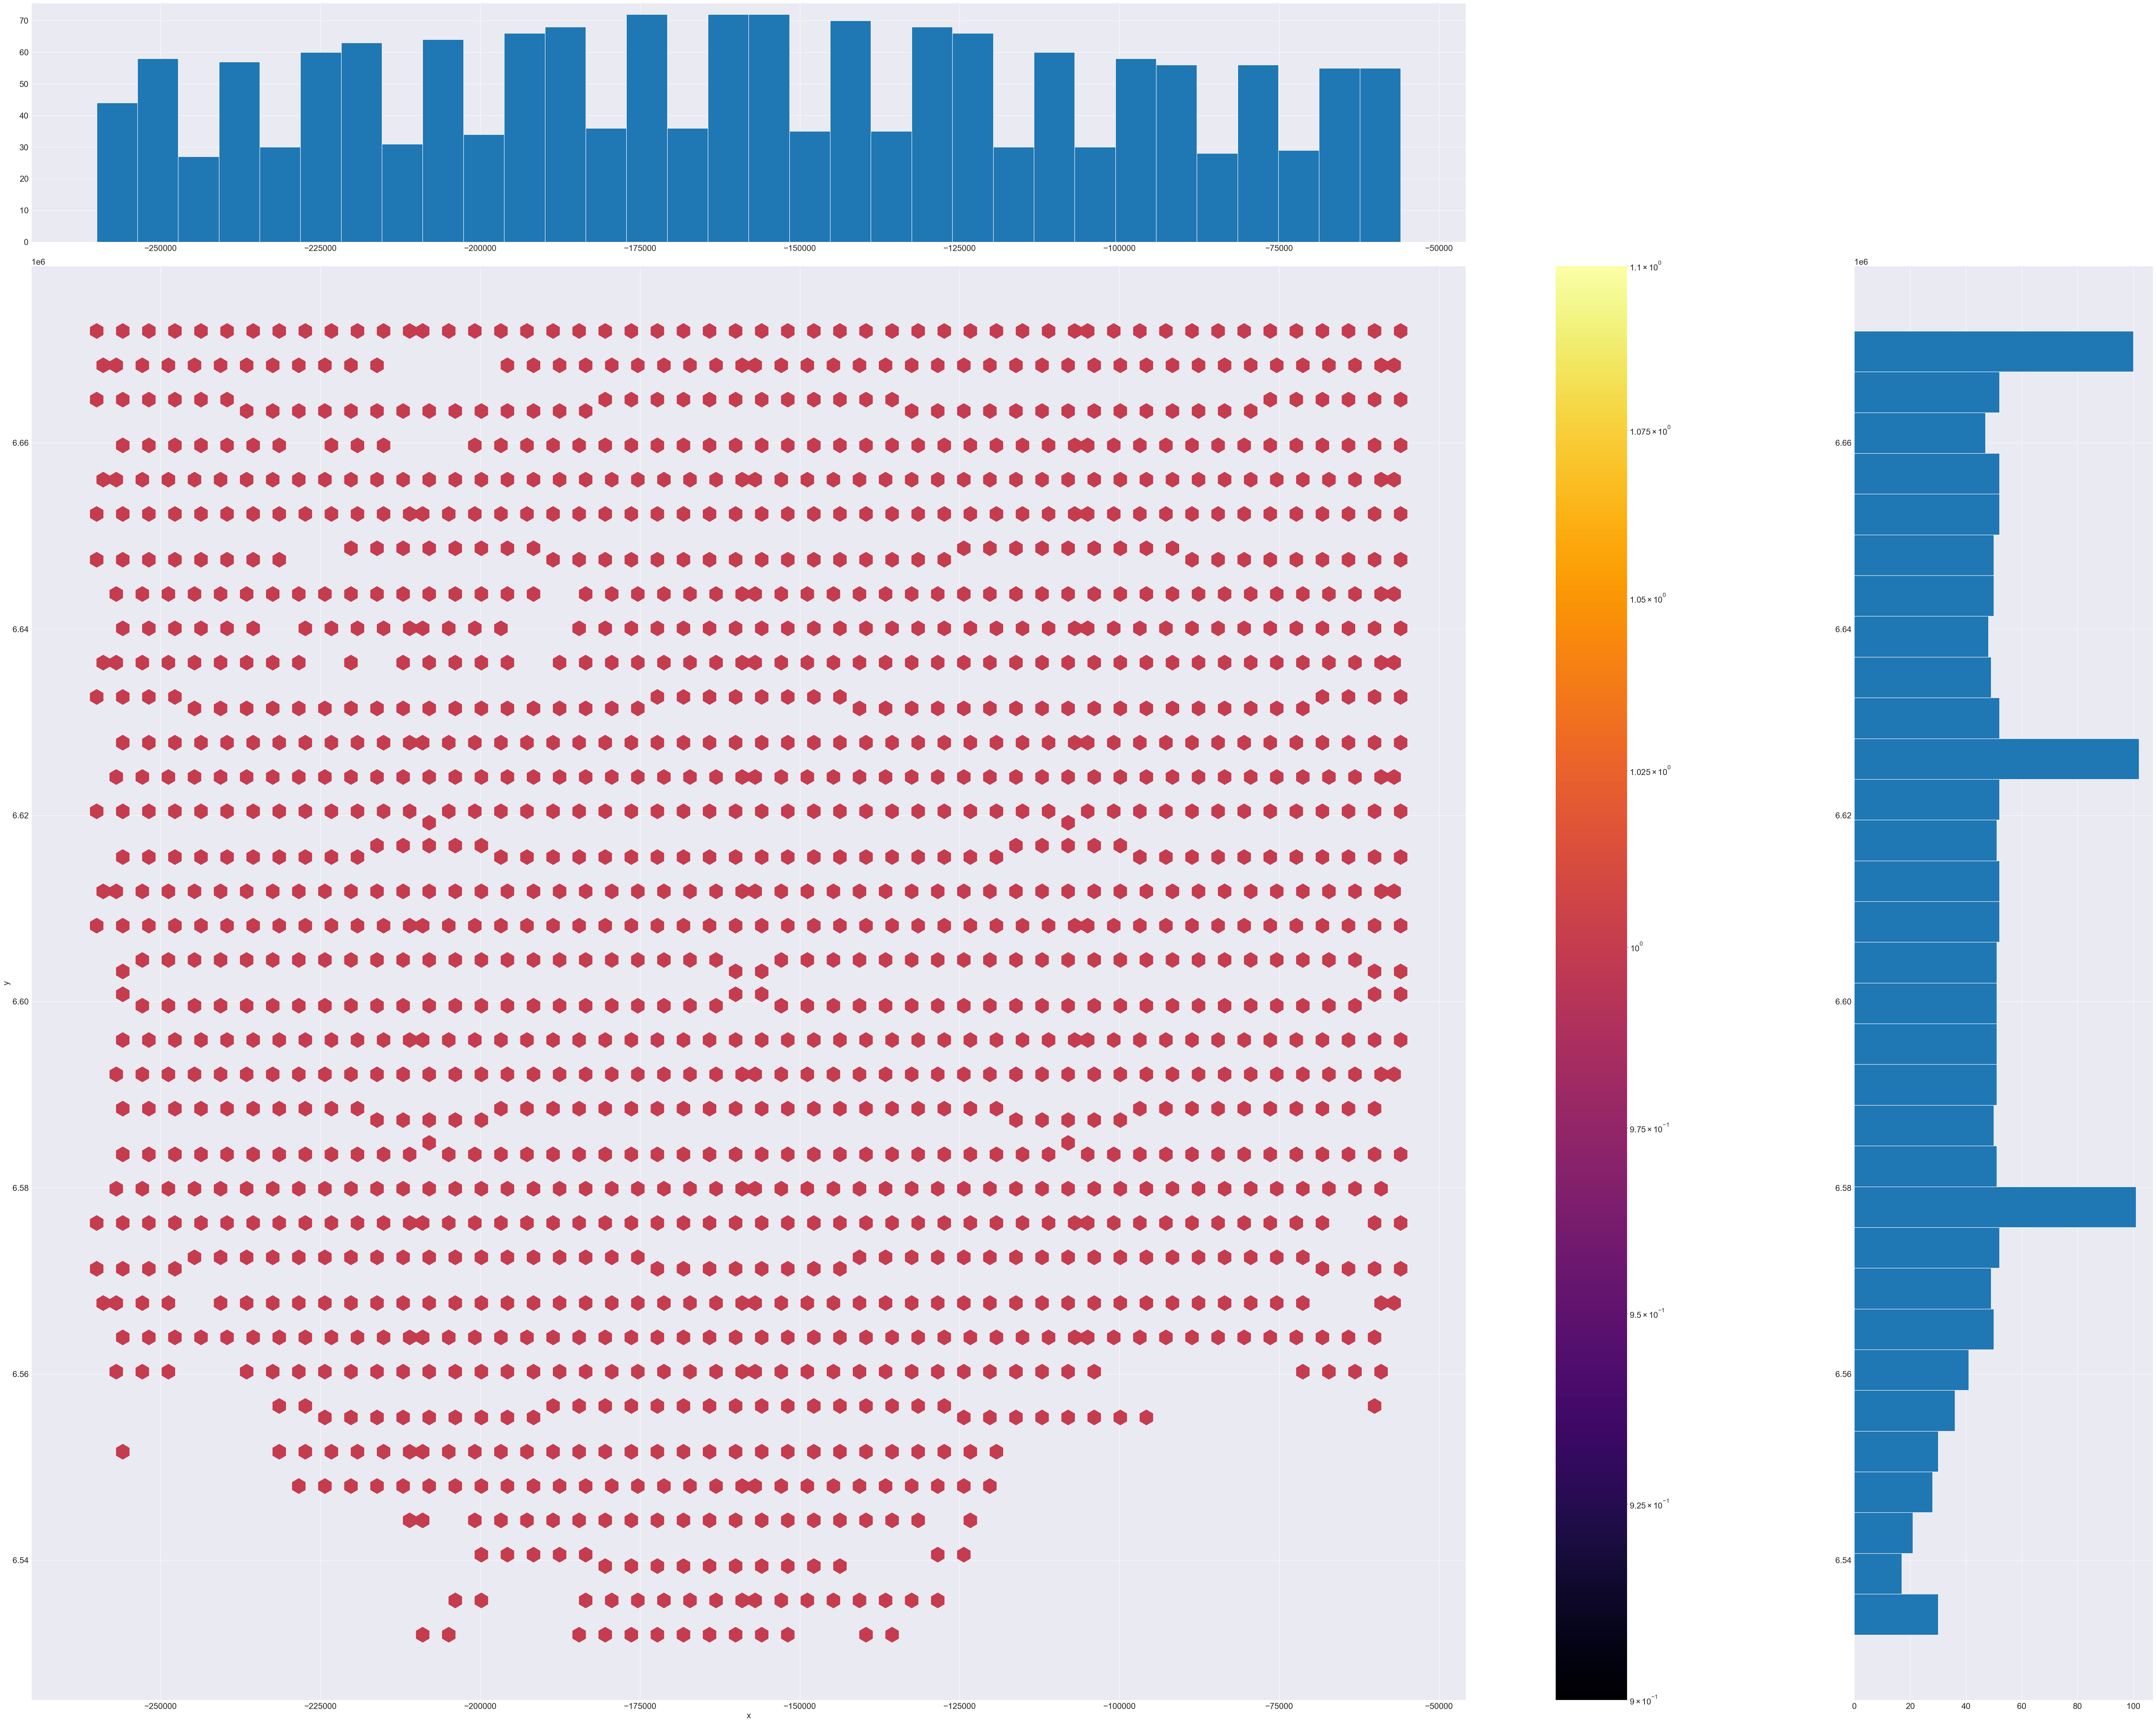

In [78]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=20)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0, 0, 6, 6])
axx = fig.add_axes([0, 6.1, 4.8, 1], sharex=ax)
axy = fig.add_axes([6.1, 0, 1, 6], sharey=ax)
tfc_agg.reset_index().plot('x', 'y', kind='hexbin', gridsize=100, bins='log', ax=ax, cmap='inferno')
tfc_agg.reset_index()['x'].hist(ax=axx, bins=32)
tfc_agg.reset_index()['y'].hist(ax=axy, orientation='horizontal', bins=32)

In [81]:
airproxes_with_tfc.explore('track_mean', cmap='inferno')

C:\ANACON~1\envs\sandbox\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


In [29]:
airproxes_with_tfc.dtypes

Latitude                     float64
Longitude                    float64
Altitude                     float64
Risk                        category
Aircraft1_Classification    category
Aircraft1_Category          category
Aircraft1_Type                object
Aircraft1_FlightRules       category
Aircraft2_Classification    category
Aircraft2_Category          category
Aircraft2_Type                object
Aircraft2_FlightRules       category
geometry                    geometry
name                          object
type                           int64
icaoClass                      int64
activity                       int64
lowerLimit_value               int64
upperLimit_value               int64
altitude                     float64
track                        float64
groundspeed                  float64
flight_id                      int64
dtype: object

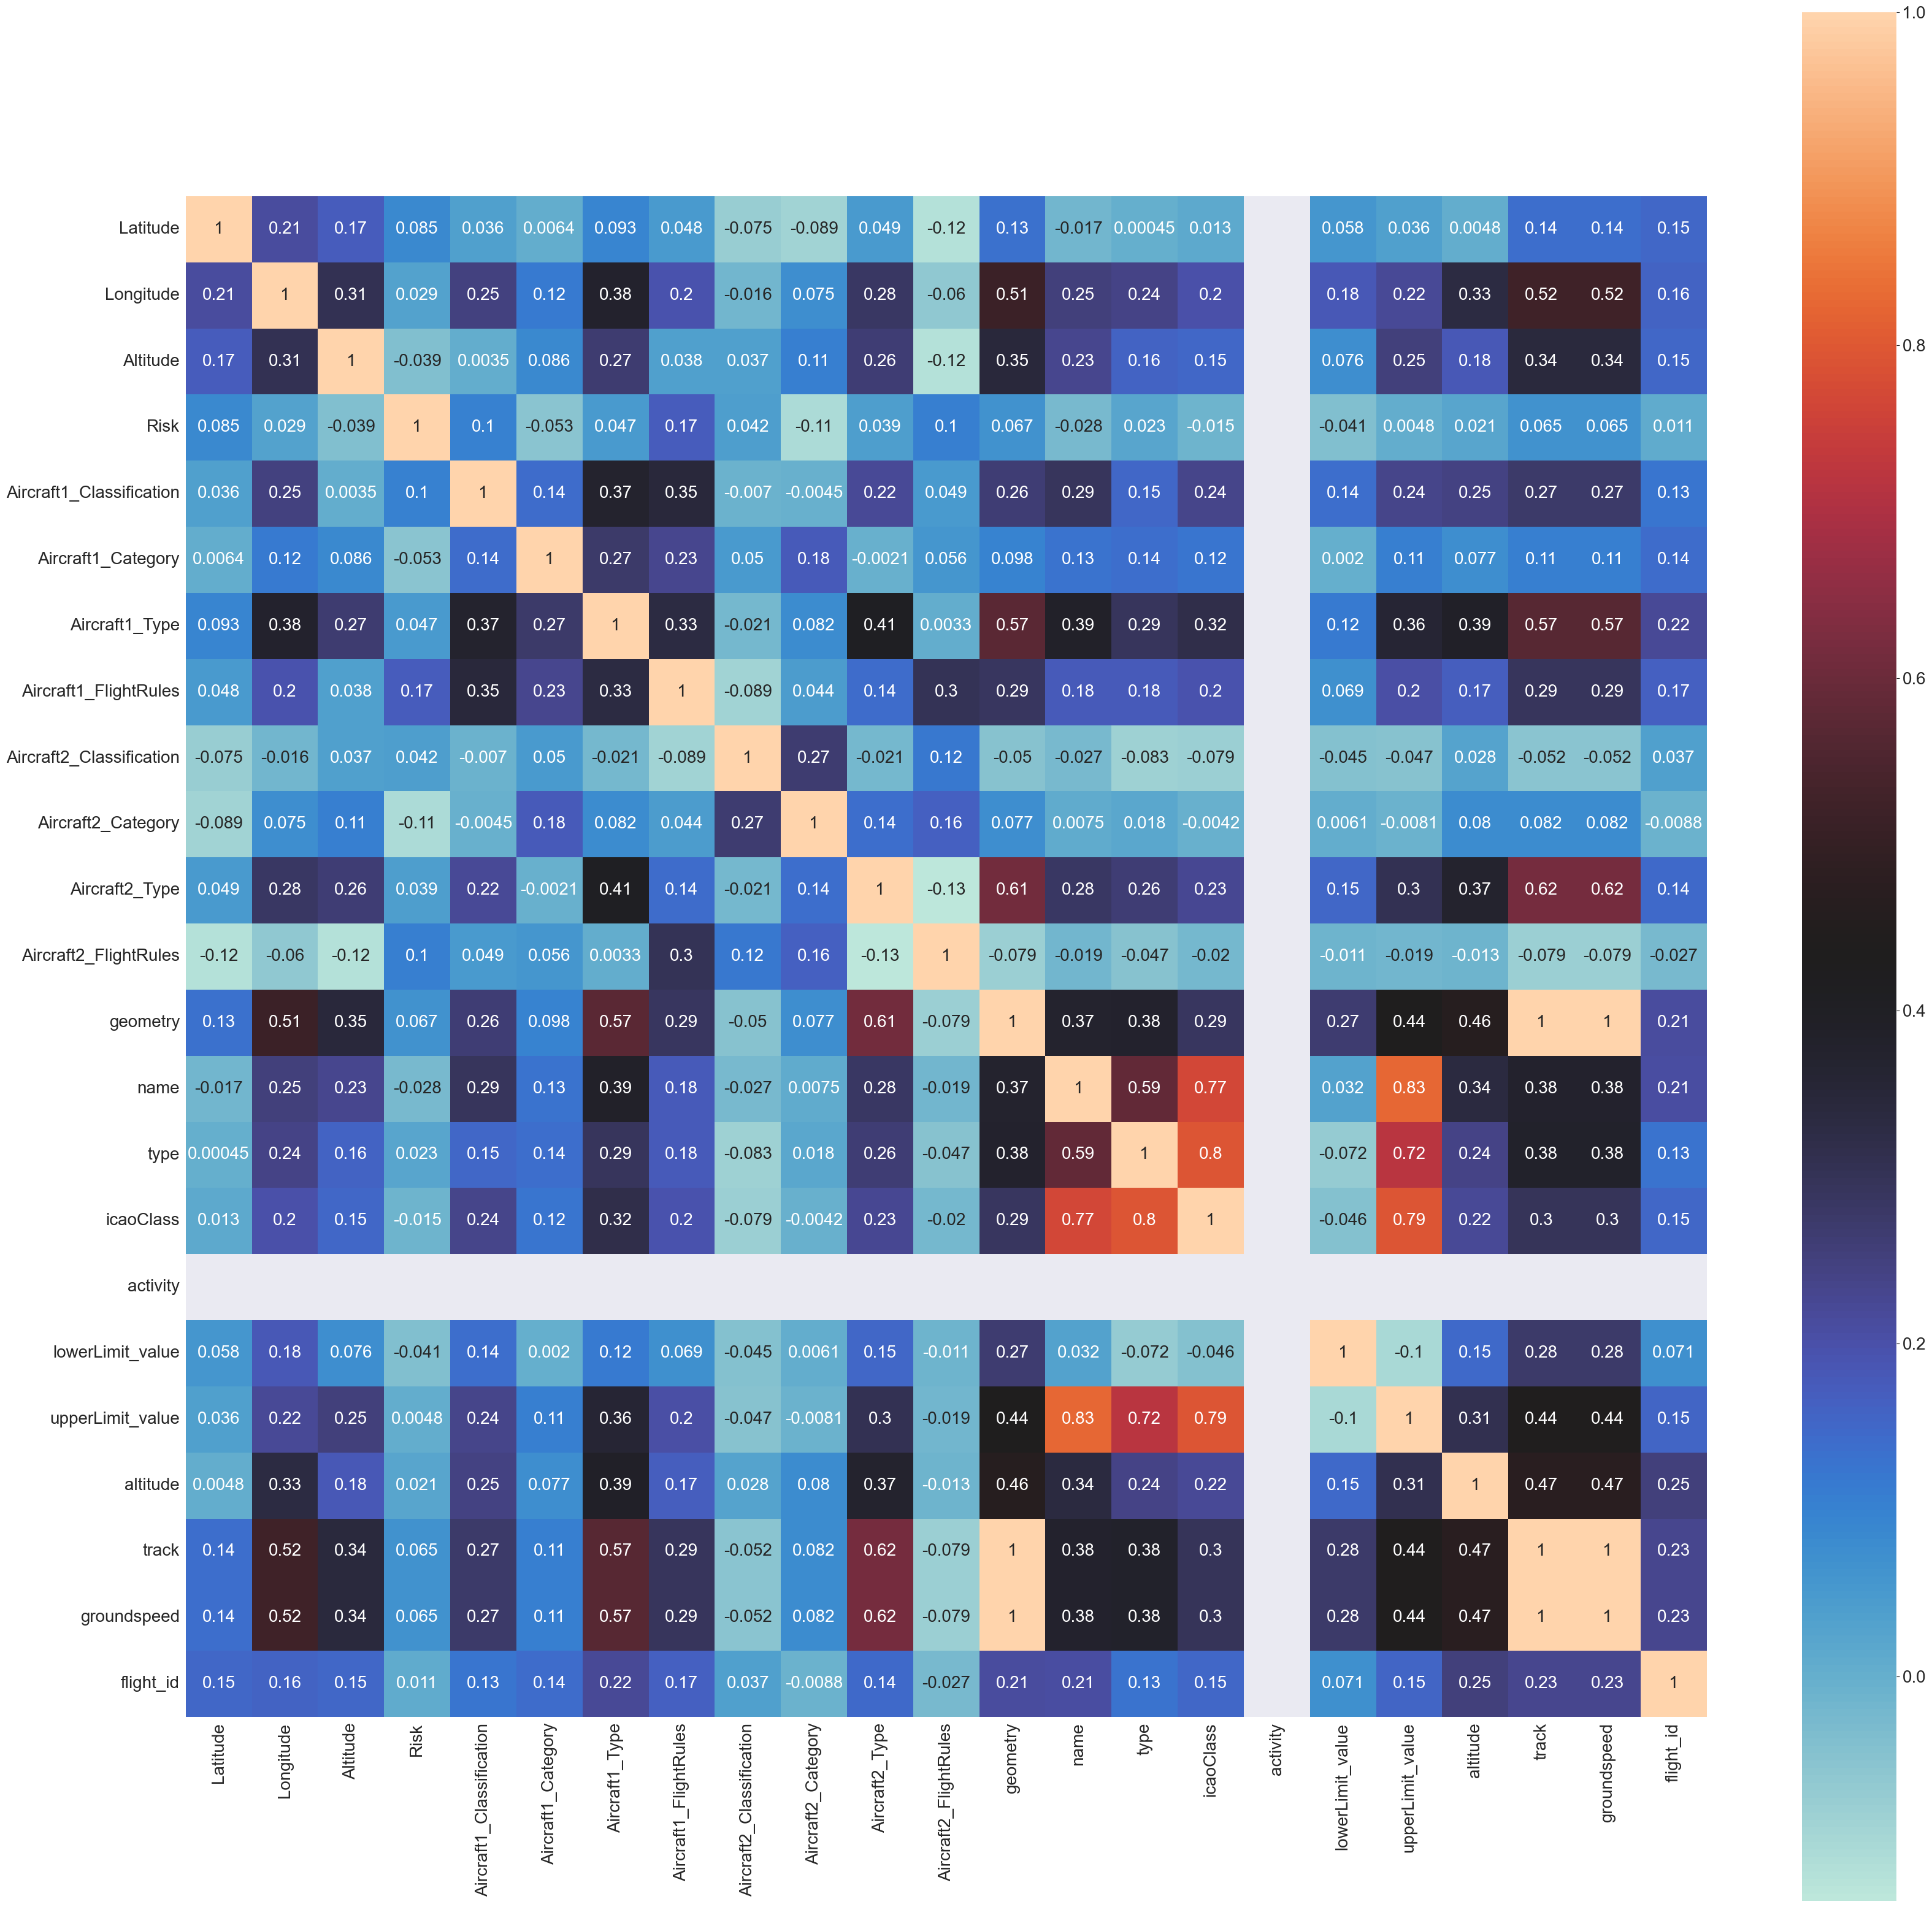

In [31]:
# corr = airproxes_with_tfc.corr(method='spearman')
corr = airproxes_with_tfc.apply(lambda x: pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(corr, square=True, cmap=sns.color_palette('icefire', as_cmap=True), annot=True, ax=ax)
plt.savefig('corr.svg', dpi=500)

In [82]:
tfc_agg.describe()

,altitude_mean,altitude_std,track_mean,track_std,groundspeed_mean,groundspeed_std,flight_id_nunique
count,1619.000000,1608.000000,1621.000000,1610.000000,1621.000000,1610.000000,1621.000000
mean,1909.719172,1075.374889,166.707758,80.560155,125.560413,31.983888,23.785935
std,1749.553364,3155.551435,54.539299,31.837132,31.500488,17.175181,70.910223
min,85.330398,0.000000,5.878977,0.000000,14.780948,0.000000,1.000000
25%,1433.679521,410.553404,133.366771,67.814234,105.810636,20.878536,5.000000
50%,1740.927445,569.667413,169.792012,87.002708,121.812500,30.675859,10.000000
75%,2043.073295,735.743113,201.572090,100.128192,142.686384,42.242900,18.000000
max,29264.700704,44426.050432,350.803344,164.630431,322.960000,129.537152,1407.000000
